# 🔍 Root Cause Analysis – Exploratory and Predictive Modeling

This notebook presents the exploratory data analysis, training, and evaluation of predictive models aimed at identifying the root causes of system failures.

The following models will be used:

- **Decision Tree**: An interpretable baseline model.
- **XGBoost**: A powerful gradient boosting model, enhanced with explainability using SHAP values.

In [1]:
from sklearn.model_selection import train_test_split

import sys
import os
sys.path.append(os.path.abspath("../src"))

from data_loader import load_data
from preprocessing import preprocess_data
from modeling import train_decision_tree, train_xgboost
from evaluation import evaluate_model

from ydata_profiling import ProfileReport
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import shap

INFO:visions.backends:Pandas backend loaded 2.2.3
INFO:visions.backends:Numpy backend loaded 1.26.4
INFO:visions.backends:Pyspark backend NOT loaded
INFO:visions.backends:Python backend loaded


In [2]:
df = load_data("../data/root_cause.csv")

In [3]:
profile = ProfileReport(df, title="Root Cause Profiling", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 215092.51it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 📊 Root Cause Dataset Profiling Summary

This document presents a summary of the exploratory data profiling report generated using `ydata-profiling` for the Root Cause Analysis dataset used in the OutSystems AI Engineer challenge.

---

## 🔍 Dataset Overview

- **Rows**: 1000
- **Columns**: 14
  - **Numerical**: 6 (`value_1` to `value_4`, `ID`)
  - **Categorical/Binary**: 8 (`error_1` to `error_7`, `issue_found`)
- **Missing values**: 0%
- **Duplicate rows**: 0%
- **Data structure**: Consistent and well-formed

---

## 📈 Numerical Feature Insights

### `value_1`
- Mean around **0.93**
- Right-skewed distribution with **27.1% negative values**
- May signal **instability or degradation**

### `value_2`, `value_3`, `value_4`
- Distributed in the **[0, 1]** range
- No missing values or extreme outliers
- Strong candidates for gradient-based models

### `ID`
- Fully unique
- Perfectly correlated
- **Redundant**, one can be dropped

---

## 🛠️ Binary Error Flags (`error_1` to `error_7`)

- Binary format: `0` or `1`
- Mostly well-distributed (e.g., `error_4`: 619 zeros, 381 ones)
- Some features such as `error_7` and `error_1` show **strong correlation with `issue_found`**
- Represent discrete **failure signals** or **symptoms**

---

## 🏷️ Target Variable – `issue_found`

- Multiclass (5 values):  
  `DATABASE_ISSUE`, `MEMORY_LEAK`, `NETWORK_GLITCH`, `POWER_OFF`, `CPU_OVERHEAT`
- Reasonably balanced class distribution
- Good fit for multiclass classification problems

---

## 🔗 Feature Correlations & Interactions

- `value_1` shows the **strongest correlation** with the target
- Certain binary error flags (e.g. `error_7`, `error_1`) also have visible predictive power
- Strong interaction patterns between specific error flags and failure types suggest that:
  - **tree-based models** (e.g., XGBoost, Random Forest) are suitable
  - **SHAP analysis** will be valuable for explainability

---

## ✅ Summary

- Clean, balanced dataset ready for supervised learning
- Key signals identified:
  - `value_1`: strongest numerical driver
  - `error_7`, `error_1`: key binary indicators
- Excellent candidate for interpretable machine learning

---

In [4]:
X, y, label_encoder = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 📋 Preprocessing Actions Summary

| Action                      | Required? | Justification                                                  |
|----------------------------|-----------|----------------------------------------------------------------|
| Remove `Unnamed: 0` / `ID` | ✅ Yes    | These are non-predictive identifiers and may introduce noise.  |
| Ensure binary type for `error_*` columns | ✅ Yes    | Already correct, but type consistency (int/bool) is important. |
| Balance classes            | 🔵 Maybe   | Consider it if recall for minority classes is a priority.      |

## Model 1: Decision Tree

INFO:root:
                precision    recall  f1-score   support

  CPU_OVERHEAT       0.73      0.50      0.59        16
DATABASE_ISSUE       1.00      1.00      1.00        59
   MEMORY_LEAK       0.97      1.00      0.98        56
 NETWORK_DELAY       0.88      0.94      0.91        48
     POWER_OFF       1.00      1.00      1.00        21

      accuracy                           0.94       200
     macro avg       0.92      0.89      0.90       200
  weighted avg       0.94      0.94      0.94       200



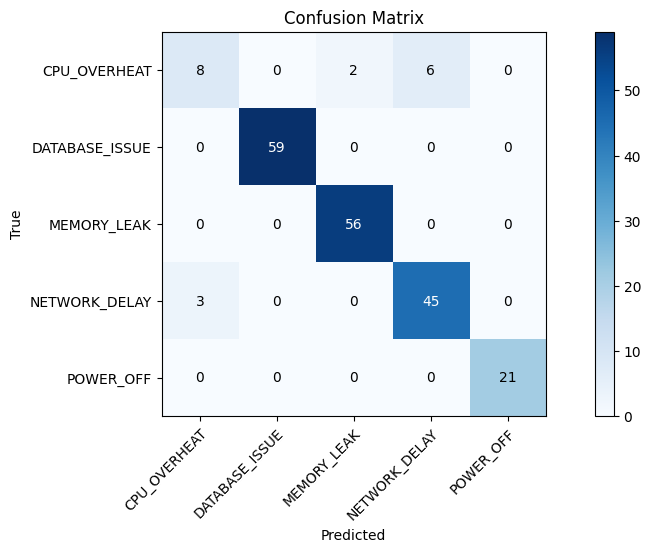

INFO:root:ROC AUC (macro-average): 0.9368
INFO:root:ROC AUC (micro-average): 0.9656


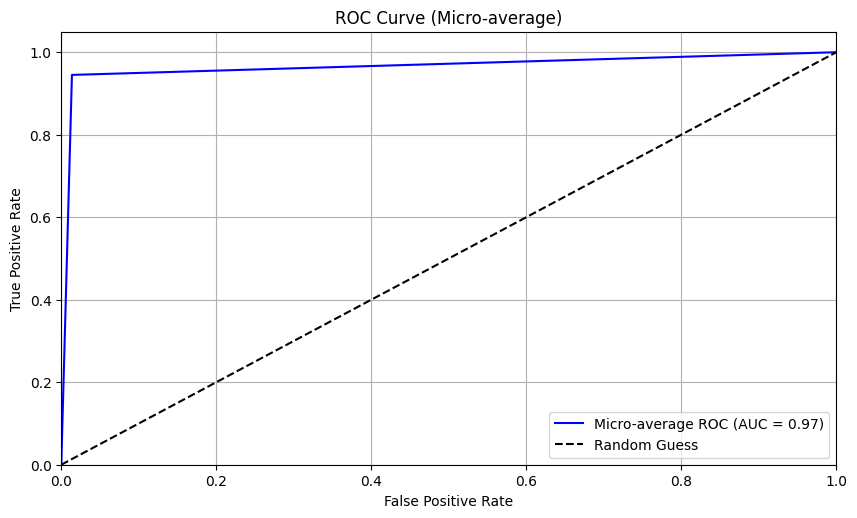

In [5]:
%matplotlib inline
dt_model = train_decision_tree(X_train, y_train)
evaluate_model(dt_model, X_test, y_test, label_encoder)

# 🌲 Decision Tree Classifier – Evaluation Summary

This report presents the evaluation results of a **Decision Tree Classifier** trained to perform root cause classification, based on a hold-out test set.

---

## 📊 Classification Metrics

| Metric           | Value |
|------------------|--------|
| **Accuracy**     | 94%   |
| **Macro F1**     | 0.90  |
| **Weighted F1**  | 0.94  |
| **Macro Recall** | 0.89  |

### Class-wise Performance:

- **CPU_OVERHEAT**
  - Precision: 0.73
  - Recall: 0.50
  - F1-score: 0.59
  - → Lower performance due to misclassifications, especially confused with `NETWORK_DELAY`.

- **DATABASE_ISSUE**
  - Perfect precision and recall (1.00)
  - Consistently predicted correctly.

- **MEMORY_LEAK**
  - Nearly perfect classification (F1-score: 0.98)

- **NETWORK_DELAY**
  - High precision (0.88) and recall (0.94)
  - Slight confusion with `CPU_OVERHEAT`.

- **POWER_OFF**
  - Perfect precision, recall, and F1-score (1.00)

---

## 📉 Confusion Matrix Insights

- **Strong diagonal structure**: Most predictions are correct.
- Misclassifications mostly affect `CPU_OVERHEAT`:
  - 6 instances misclassified as `NETWORK_DELAY`
  - 2 as `MEMORY_LEAK`
- All other classes are clearly distinguished.

➡️ Suggests that `CPU_OVERHEAT` may need additional engineered features to improve separability.

---

## 📈 ROC AUC Results

- **Macro-Averaged ROC AUC**: 0.9368
- **Micro-Averaged ROC AUC**: 0.9656

### Interpretation:
- ROC curves confirm **very good generalization** for all classes.
- While the ROC AUC is slightly lower than XGBoost’s, it remains excellent and confirms the classifier's robustness.

---

## ✅ Summary

- The Decision Tree achieves **94% accuracy**, nearly on par with XGBoost.
- It is **interpretable** and suitable for rule-based diagnostics.
- Performance is excellent for all classes **except `CPU_OVERHEAT`**, which suffers from some overlap with `NETWORK_DELAY`.

**Recommendation**: Use this model when explainability and interpretability are preferred over minimal performance gains. For production-grade robustness, consider XGBoost or an ensemble.

## Model 2: XGBoost

INFO:root:
                precision    recall  f1-score   support

  CPU_OVERHEAT       0.75      0.56      0.64        16
DATABASE_ISSUE       0.98      1.00      0.99        59
   MEMORY_LEAK       0.96      0.98      0.97        56
 NETWORK_DELAY       0.90      0.94      0.92        48
     POWER_OFF       1.00      1.00      1.00        21

      accuracy                           0.94       200
     macro avg       0.92      0.90      0.91       200
  weighted avg       0.94      0.94      0.94       200



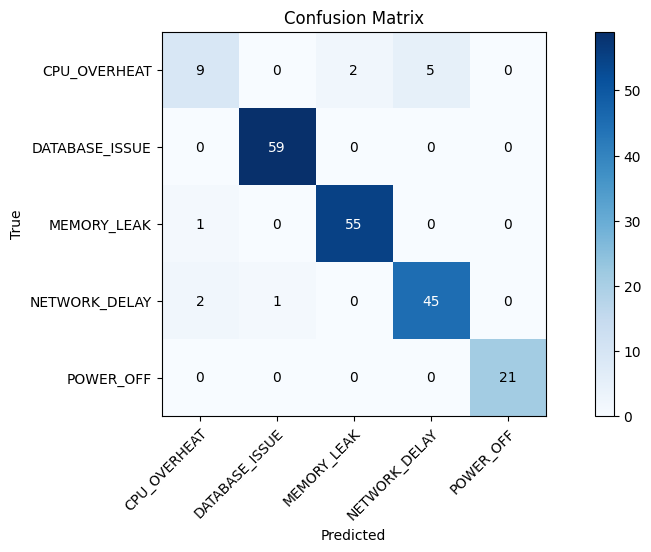

INFO:root:ROC AUC (macro-average): 0.9901
INFO:root:ROC AUC (micro-average): 0.9958


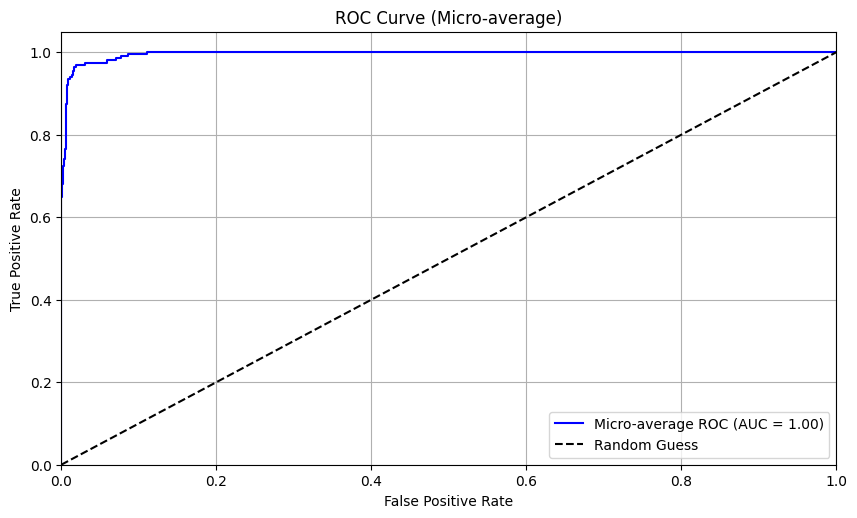

In [6]:
%matplotlib inline
xgb_model = train_xgboost(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, label_encoder)

# ✅ XGBoost Model Evaluation Summary

This document summarizes the performance of the XGBoost classifier on the Root Cause Analysis dataset, based on classification metrics, the confusion matrix, and ROC AUC scores.

---

## 📊 Classification Metrics

| Metric           | Value |
|------------------|--------|
| **Accuracy**     | 94%   |
| **Macro F1**     | 0.91  |
| **Weighted F1**  | 0.94  |
| **Macro Recall** | 0.90  |

### Class-wise Performance:

- **CPU_OVERHEAT**
  - Precision: 0.75
  - Recall: 0.56
  - F1-score: 0.64
  - → This is the weakest class in terms of recall.

- **DATABASE_ISSUE**
  - Precision: 0.98, Recall: 1.00, F1: 0.99
  - Perfectly identified in almost all cases.

- **MEMORY_LEAK**
  - Very high precision and recall (0.96–0.98)

- **NETWORK_DELAY**
  - Strong recall (0.94), F1: 0.92

- **POWER_OFF**
  - Perfect classification (Precision/Recall/F1 = 1.00)

---

## 📉 Confusion Matrix Insights

- The model is very accurate in distinguishing **DATABASE_ISSUE**, **MEMORY_LEAK**, and **POWER_OFF**.
- There is some **confusion between `CPU_OVERHEAT` and `NETWORK_DELAY`** (5 instances misclassified).
- A few isolated misclassifications (e.g., 2 NETWORK_DELAY predicted as CPU_OVERHEAT).

➡️ **CPU_OVERHEAT** shows the most confusion and may benefit from additional or engineered features.

---

## 📈 ROC AUC Results

- **Micro-Averaged ROC AUC**: 0.9958
- **Macro-Averaged ROC AUC**: 0.9901

### Interpretation:
- Both scores indicate **exceptionally strong model performance** across all classes.
- The ROC curve shows that the model almost perfectly distinguishes between classes — especially impressive for a multiclass scenario.

---

## ✅ Summary

- The XGBoost model performs **very well overall** with a **94% accuracy**.
- `DATABASE_ISSUE`, `MEMORY_LEAK`, and `POWER_OFF` are almost perfectly classified.
- `CPU_OVERHEAT` is the weakest class — consider improving it with additional domain knowledge or signal engineering.
- High ROC AUC scores confirm that the classifier is reliable and well-calibrated.

## Interpretability with plot_tree (DecisionTree)

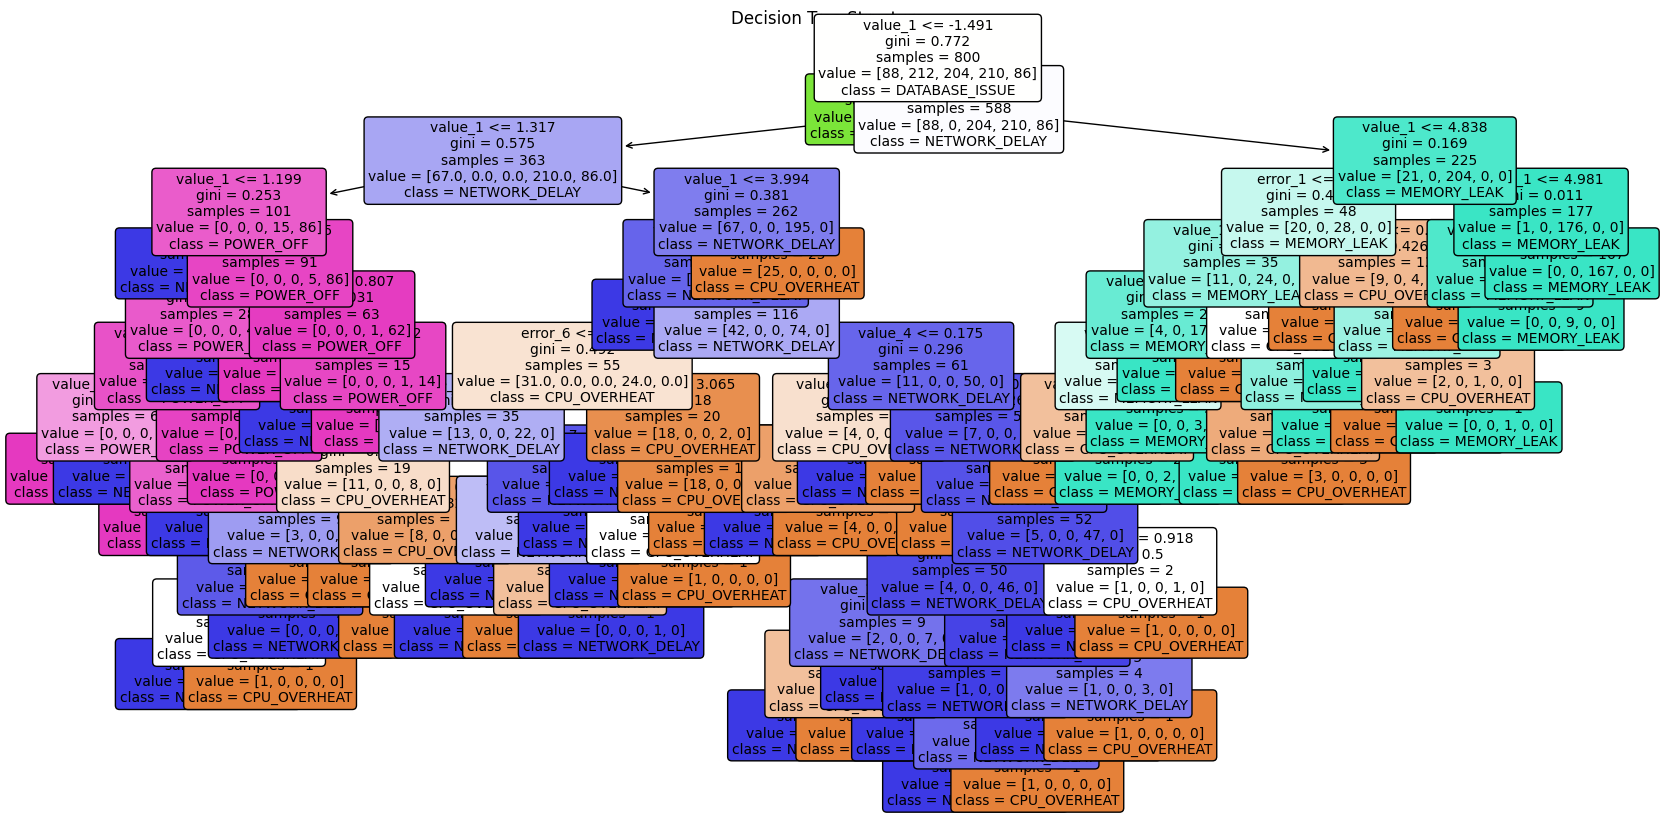

In [7]:
%matplotlib inline
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,              # seu modelo treinado
    feature_names=X.columns,
    class_names=label_encoder.classes_,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.show()


# 🌳 Decision Tree Interpretability Report

This section provides an interpretation of the trained Decision Tree used for root cause classification. The tree is visualized as a set of decision rules based on feature thresholds, helping us understand how predictions are made.

---

## 🧠 Tree Structure Overview

- The **root node** uses the feature `value_1` to make the initial split.
- Subsequent splits rely on features like `error_1`, `value_4`, and other `error_*` flags.
- Each leaf node represents a predicted class and shows the number of training samples that reached it.

### Key elements per node:
- `value_1 <= x.x`: decision threshold for splitting
- `gini`: impurity measure (closer to 0 = purer node)
- `samples`: number of examples in the node
- `value`: count of samples per class
- `class`: majority class prediction

---

## 🔍 Interpretability Insights

### 🔹 Root Split

```text
value_1 <= -1.491
gini = 0.772
samples = 800
class = DATABASE_ISSUE
```

- This is the most important split.
- `value_1` is the strongest predictor and determines the top-level branching.
- When `value_1` is low (≤ -1.491), the model predicts `DATABASE_ISSUE`.

---

### ➡️ MEMORY_LEAK Path

```text
value_1 > 4.838 → class = MEMORY_LEAK
```

- High `value_1` values lead to a confident prediction of `MEMORY_LEAK`.
- Gini = 0.169 implies very high purity.

---

### ➡️ CPU_OVERHEAT Paths

- Multiple paths converge to `CPU_OVERHEAT`, often involving:
  - Mid-range `value_1`
  - Certain error flags being absent
- Example path:
  ```text
  value_1 <= 3.994
  error_1 <= 0.5
  → class = CPU_OVERHEAT
  ```

---

### ➡️ NETWORK_DELAY Paths

- Typically appears when:
  - `value_1` is between -1.5 and ~3.9
  - Combined with thresholds like `value_4 <= 0.175` and specific error codes
- Shares several nodes with `CPU_OVERHEAT`, explaining some confusion between them.

---

### ➡️ POWER_OFF

- Appears when:
  - `value_1` is low
  - No other significant error features are present
- Consistently well-separated due to low Gini impurity.

---

## ⚠️ Observations

- `value_1` is the dominant feature across most paths — consistent with SHAP analysis.
- The model is highly interpretable, with rules that can be easily reviewed by engineers.
- `CPU_OVERHEAT` and `NETWORK_DELAY` share overlapping decision space — this aligns with the confusion seen in the confusion matrix.

---

## ✅ Summary

- The Decision Tree provides transparent and explainable predictions.
- Features like `value_1`, `error_1`, and `value_4` play key roles in classification.
- The tree structure validates the overall model logic and supports trust in predictions.


## Explicability with SHAP (XGBoost)

PermutationExplainer explainer: 201it [00:15,  5.53it/s]                         


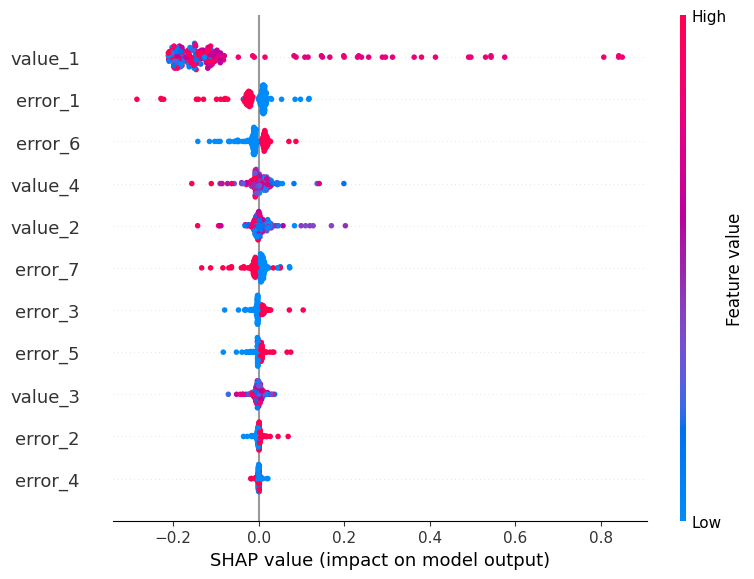

In [8]:
%matplotlib inline
shap.initjs()

explainer = shap.Explainer(xgb_model.predict_proba, X_train)
shap_values = explainer(X_test)

# Plot para a classe 0 (você pode mudar o índice para outra classe)
shap.summary_plot(shap_values[..., 0], X_test, feature_names=X.columns)

# 🔍 SHAP Summary – Feature Impact on Model Predictions

This SHAP summary plot visualizes the **impact of each feature on the XGBoost model output** for a given class (likely class 0). It is based on SHAP values, which quantify how much each feature contributes (positively or negatively) to a prediction, on a per-instance basis.

---

## 📌 How to Read the Plot

- **Y-axis**: Features sorted by importance (top to bottom).
- **X-axis**: SHAP value → positive pushes prediction higher; negative lowers it.
- **Color**: Value of the feature (red = high, blue = low).

Each dot represents a single prediction (row). Its location on the X-axis shows the **impact**, and its color indicates the **feature value**.

---

## 🔝 Most Influential Features

### 1. `value_1`
- **Highest impact overall**.
- High values (red) strongly **increase the model's output**.
- Low values (blue) are tightly clustered and have negative or near-zero influence.
- Suggests that `value_1` is a **key driver** of the model's decision — possibly a risk indicator or degradation metric.

### 2. `error_1`
- Binary feature; mostly two clear clusters.
- When present (`1`), it tends to **shift the prediction positively**.
- Its absence has near-zero or negative effect — meaning it's a strong flag when active.

### 3. `value_4`, `value_2`, `value_3`
- Moderate influence, symmetric around zero.
- Can increase or decrease the prediction based on value.
- Likely continuous signals that support the main prediction.

---

## 🔻 Less Influential Features

- `error_2`, `error_3`, `error_5`, `error_4`: Limited overall contribution.
- Their SHAP values are close to 0 in most instances.
- Still useful in rare cases (outliers may hold domain importance).

---

## 🧠 Interpretability Insights

- The model is **mostly driven by `value_1` and binary error flags**.
- SHAP values show how **interactions between features influence predictions**, making the model decisions explainable.
- This supports both **trust** and **debugging** by showing which features are responsible for which outputs.

---

## ✅ Summary

- `value_1` is the **dominant predictor** in the model.
- `error_1`, `error_6`, and `error_7` are **important binary indicators**.
- The model is explainable and appears to be relying on meaningful, sparse signals — suitable for real-world RCA (Root Cause Analysis) applications.